<a href="https://colab.research.google.com/github/tomunizua/air_quality_forecasting-formative1/blob/main/air_quality_forecasting_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
import os
from tensorflow.keras.utils import plot_model
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/time_series_assignment/train.csv')
test = pd.read_csv('/content/drive/MyDrive/time_series_assignment/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [12]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# Drop the 'No' column as it's an identifier and not a feature
if 'No' in train.columns:
    train.drop(columns=['No'], inplace=True)
    print("Dropped 'No' column.")

Dropped 'No' column.


In [7]:
# Checking for data types and identifying non-null counts
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEWP     30676 non-null  float64
 1   TEMP     30676 non-null  float64
 2   PRES     30676 non-null  float64
 3   Iws      30676 non-null  float64
 4   Is       30676 non-null  float64
 5   Ir       30676 non-null  float64
 6   cbwd_NW  30676 non-null  float64
 7   cbwd_SE  30676 non-null  float64
 8   cbwd_cv  30676 non-null  float64
 9   pm2.5    28755 non-null  float64
dtypes: float64(10)
memory usage: 2.6 MB


In [8]:
# Summary statistics for numerical columns,
# to understand the range and distribution of values
train.describe()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
# Reconfirming and handling missing values
print("\nMissing values before final handling:")
print(train.isnull().sum())


Missing values before final handling:
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


Use forward-fill followed by backward-fill to impute missing points with the most recent known value, preserving the time-dependent patterns and characteristics of the series. This is better tnan using the mean, which can smooth out important patterns and not allow the model learn effectively.

In [8]:
# Applying forward-fill followed by backward-fill to ensure no NaNs
train.ffill(inplace=True)
train.bfill(inplace=True)

print("\nMissing values after final handling:")
print(train.isnull().sum().sum())
if train.isnull().sum().sum() == 0:
    print("All missing values successfully handled.")
else:
    print("Warning: Missing values still present. Review data.")


Missing values after final handling:
0
All missing values successfully handled.


#Visualisations of the dataset

The time series plot below helps identify seasonality and trends over the entire dataset period, which are the primary characteristics that RNNs/LSTMs are designed to capture. It also reveals the patterns the model needs to learn.

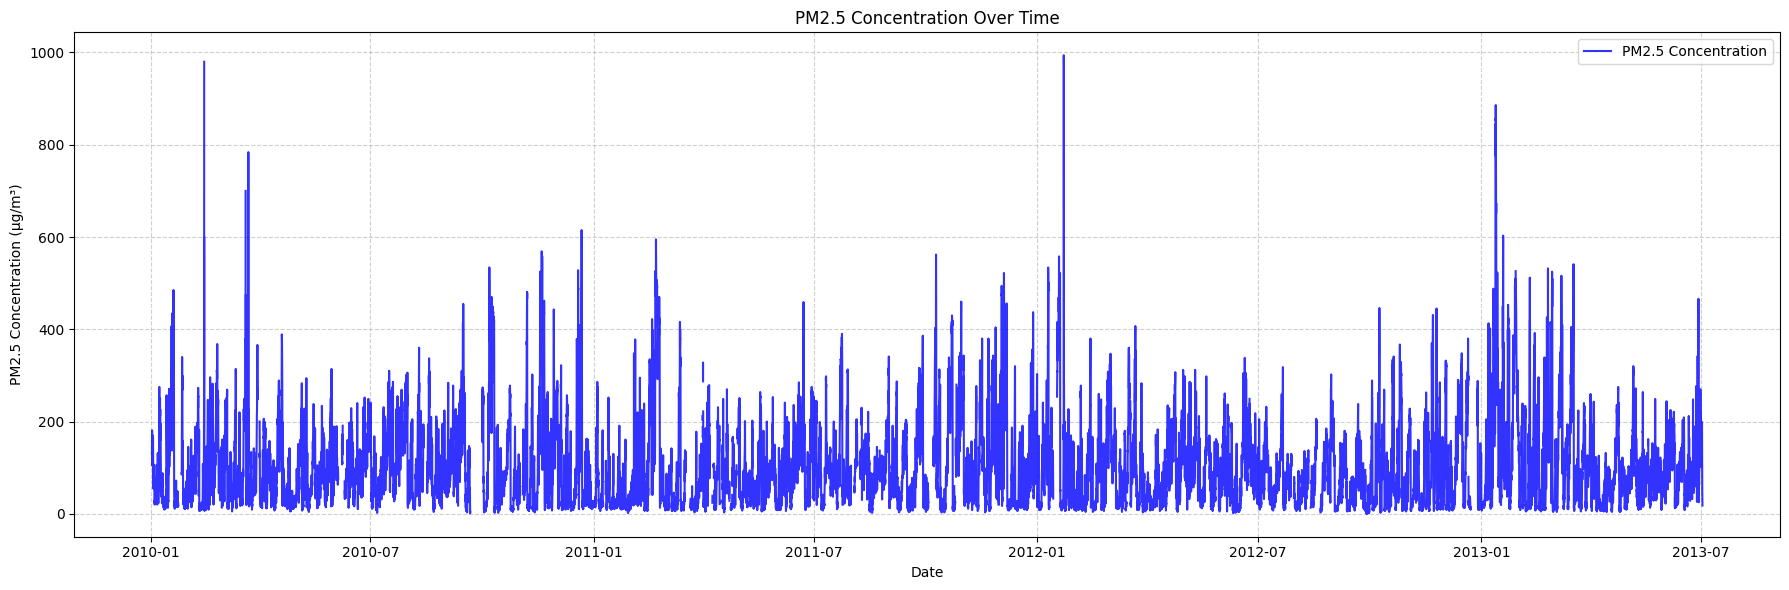

In [9]:
# Visualize PM2.5 time series
plt.figure(figsize=(18, 6))
plt.plot(train['pm2.5'], label='PM2.5 Concentration', color='blue', alpha=0.8)
plt.title('PM2.5 Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration (μg/m³)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Histograms display the distribution of individual numerical features. The histograms below show how frequesntly different values occur for each feature. This reveals underlying statistical properties of the data and informs the normalization method chosen to maximize the model's performance.

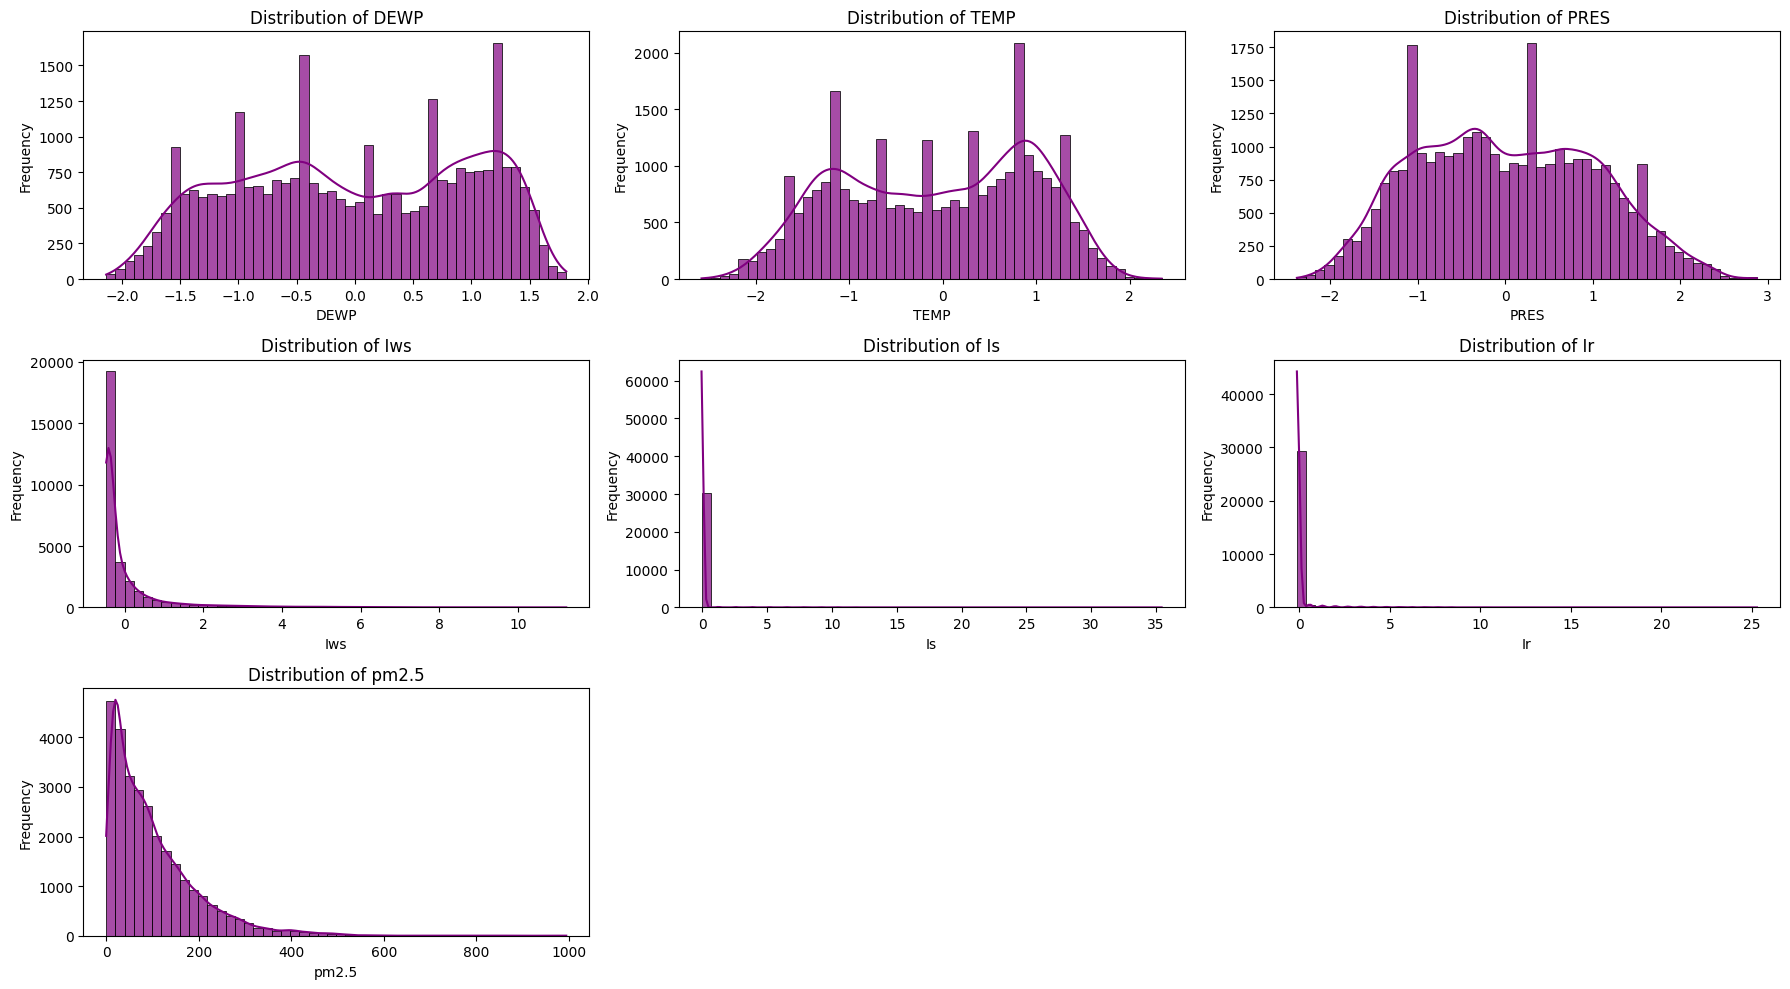

In [10]:
# Exclude one-hot encoded columns and the newly created categorical one
numerical_cols_for_hist = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']
if 'pm2.5' not in numerical_cols_for_hist:
    numerical_cols_for_hist.append('pm2.5') # Ensure target is included

plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols_for_hist):
    if col in train.columns: # Robust check
        plt.subplot(3, 3, i + 1) # Adjust subplot grid as needed
        sns.histplot(train[col], kde=True, bins=50, color='purple', alpha=0.7)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Seasonal decomposition is used to break the time series data into trend, seasonal, and residual components, helping to better understand underlying patterns in PM2.5 levels. This insight allowed for more informed preprocessing and model design by highlighting repeating cycles and long-term trends that could affect predictions.

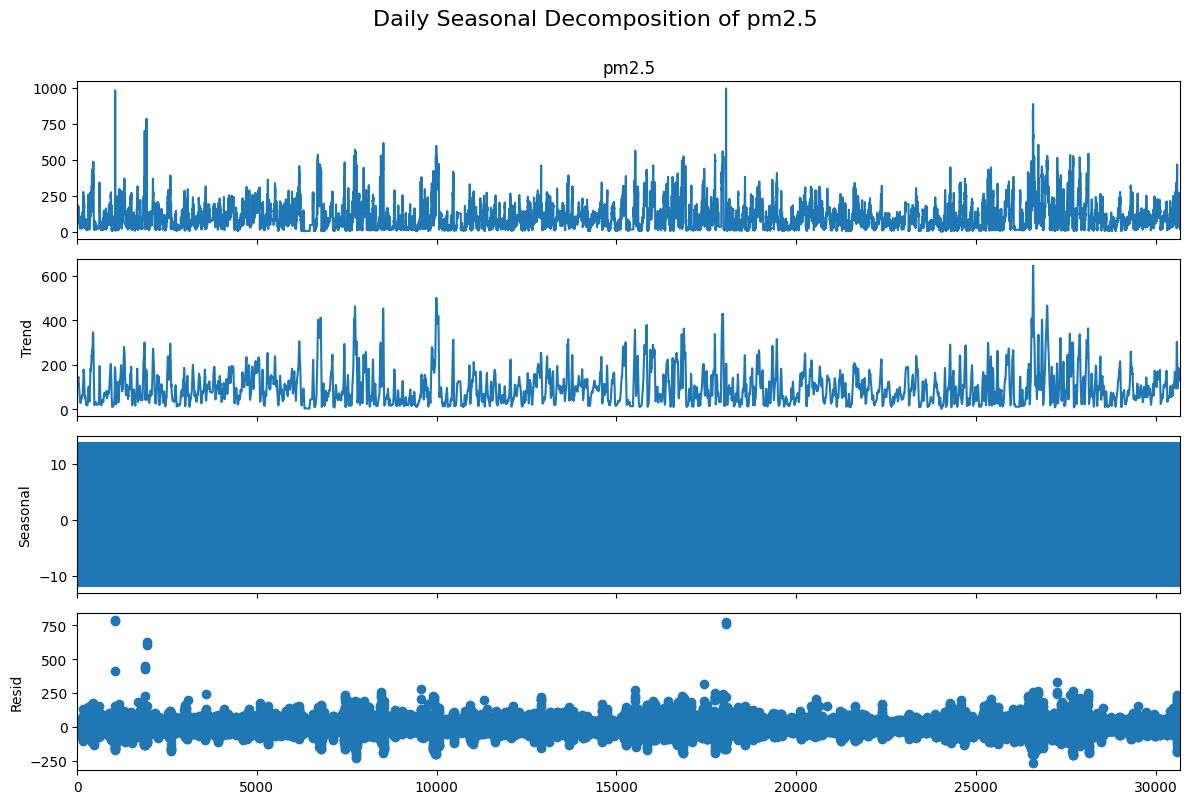

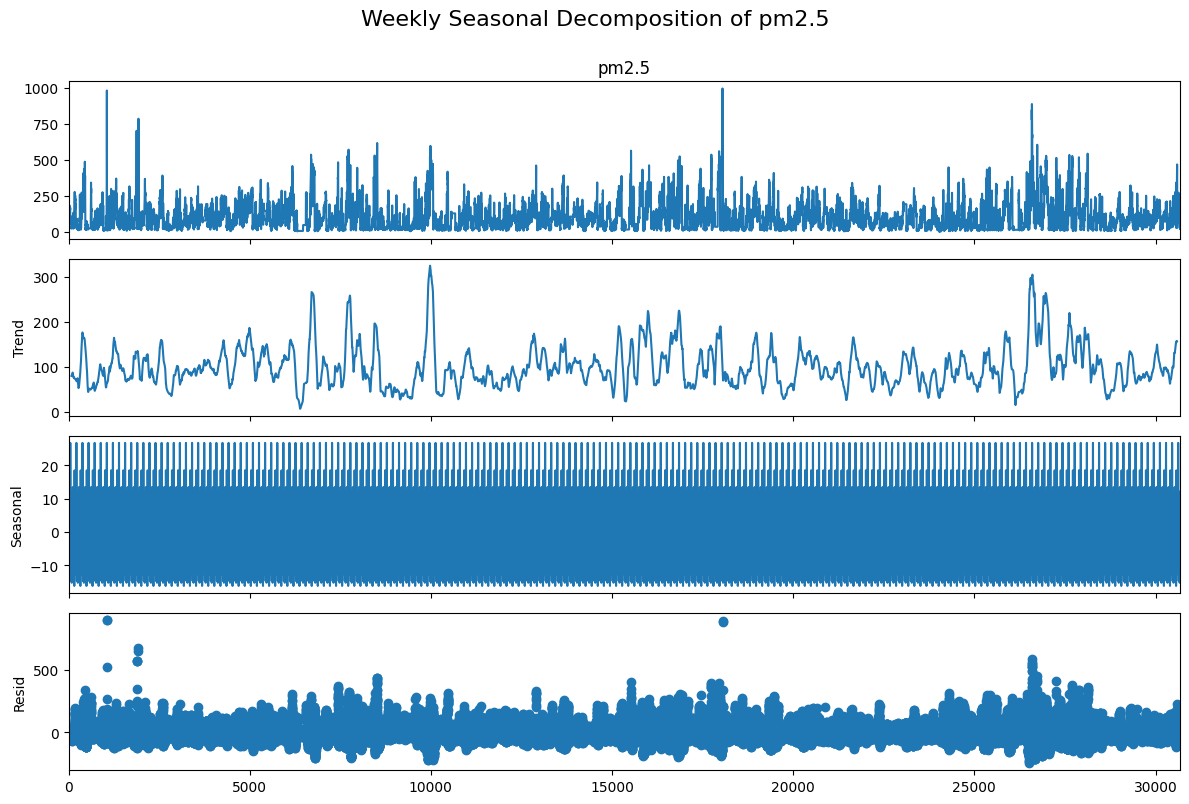

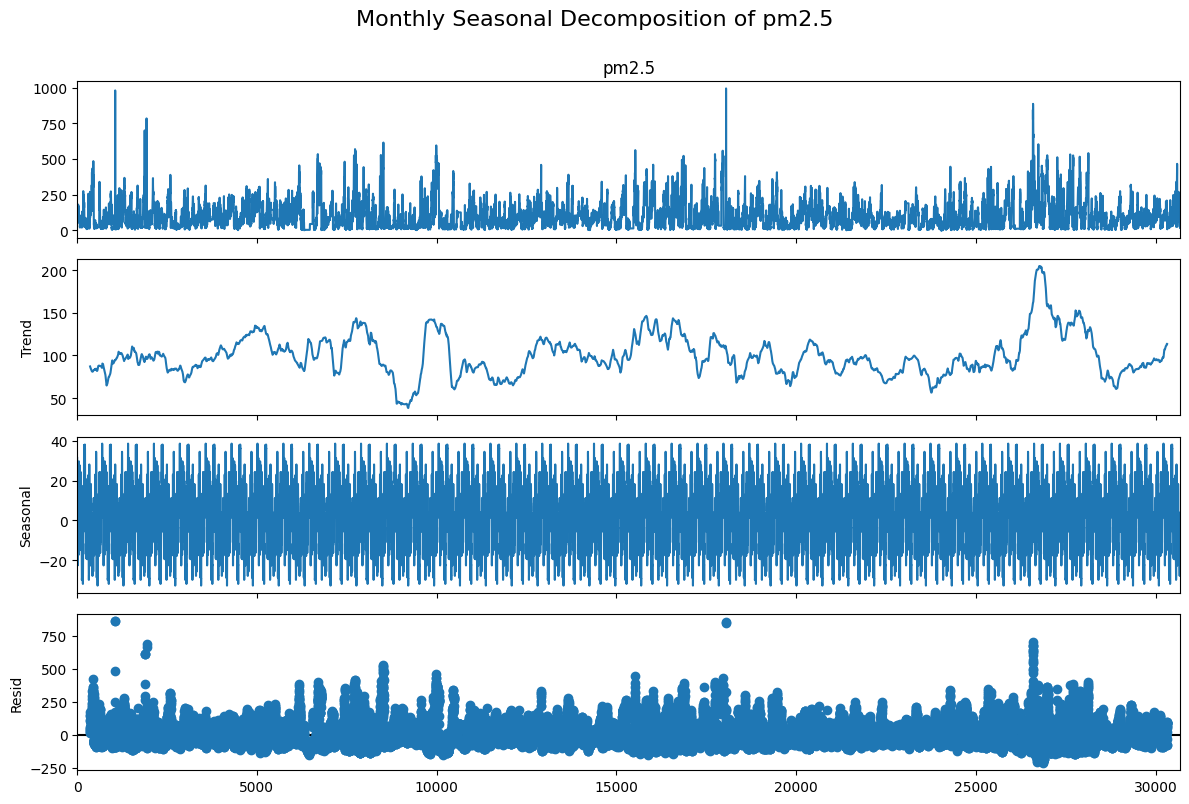

In [9]:
# Perform seasonal decomposition

for period, name in [(24, 'Daily'), (168, 'Weekly'), (720, 'Monthly')]:
    result = seasonal_decompose(train['pm2.5'], model='additive', period=period)

    fig = result.plot()
    fig.set_size_inches(12, 8)

    # Set suptitle with vertical position adjusted to avoid overlap
    plt.suptitle(f'{name} Seasonal Decomposition of pm2.5', fontsize=16, y=1)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

Correlation heatmaps show the strength and direction of linear relationships between pairs of numerical variables. It is necessary for feature selection as it highlifhts features with strong correlations to our target (in this case pm2.5), indicating they are potentially good predictors.

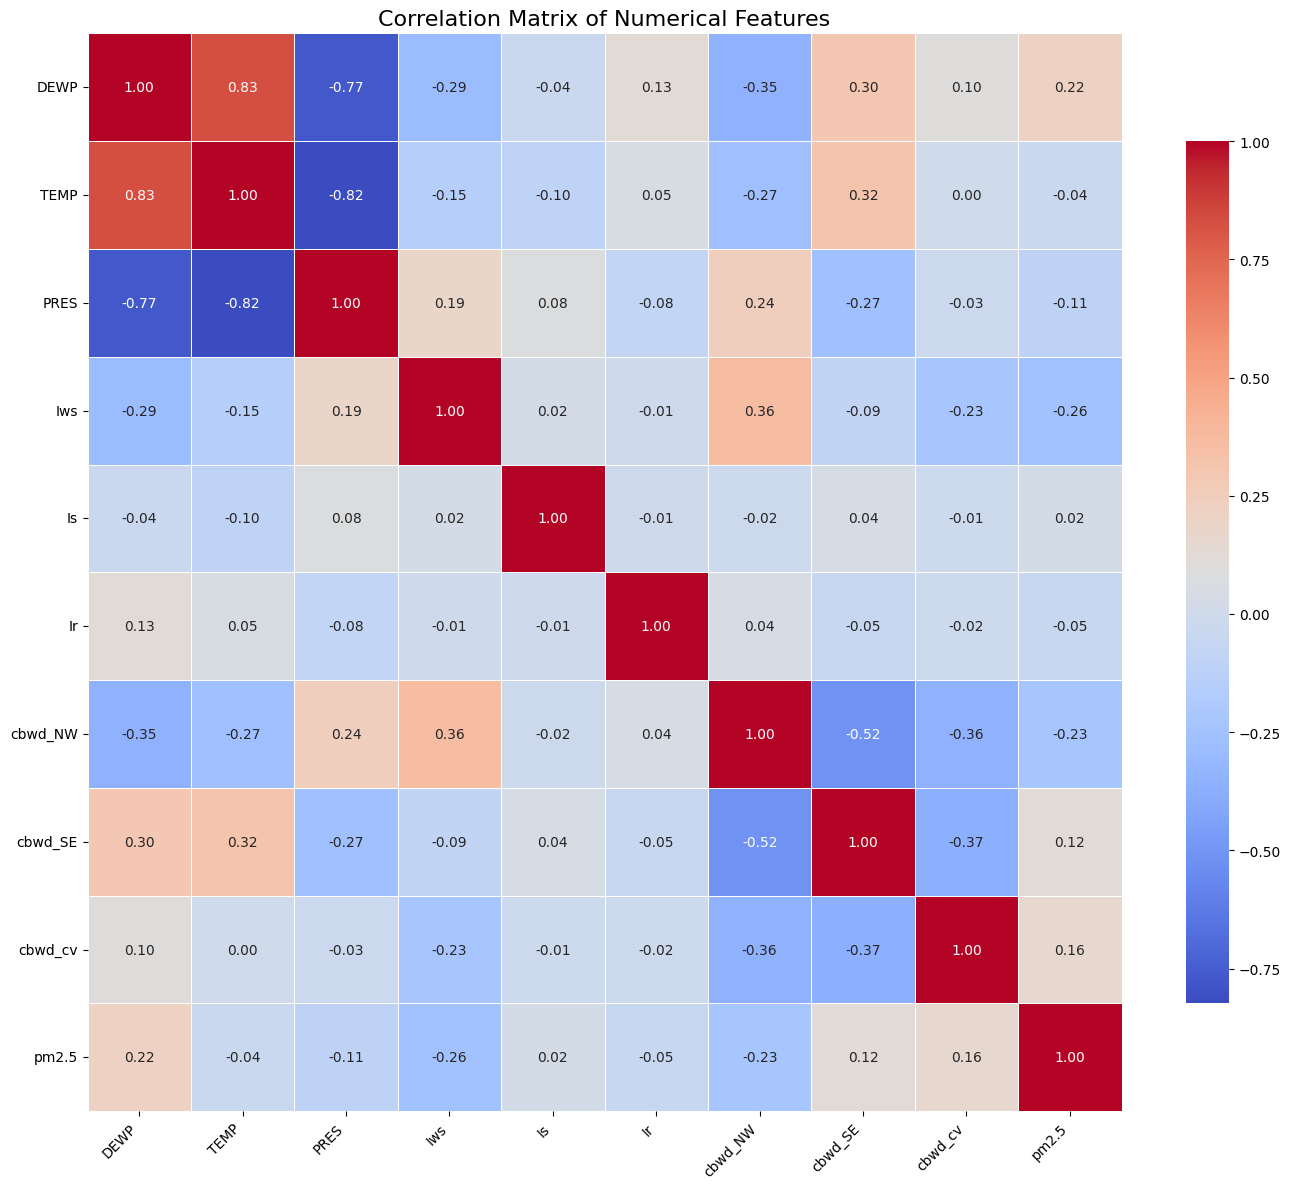

In [11]:
# Select only numerical columns for correlation calculation
numerical_df = train.select_dtypes(include=np.number)

plt.figure(figsize=(14, 12))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

Normalization of the data is important as neural networks are highly sensitive to the scale of input features. Features with larger numerical ranges can dominate the learning process, leading to unstable gradients, slower convergence, and worse model performance. Scaling transforms all features into a consistent range.

In [13]:
# Define features (X) and target (y)
target_column = 'pm2.5'
features_columns = [col for col in train.columns if col != target_column]

X = train[features_columns]
y = train[target_column]

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Initialize MinMaxScaler for both features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform features (X)
X_scaled = scaler_X.fit_transform(X)

# Transform target (y)
# Reshape y to 2D array for scaler compatibility
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

print("\nShape of scaled features (X_scaled):", X_scaled.shape)
print("Shape of scaled target (y_scaled):", y_scaled.shape)


Features (X) shape: (30676, 9)
Target (y) shape: (30676,)

Shape of scaled features (X_scaled): (30676, 9)
Shape of scaled target (y_scaled): (30676, 1)


Time Windowing: Creating input-output sequences through time windowing is fundamentally relevant to the performance of RNN and LSTM models because these architectures are specifically designed to learn from the temporal dependencies and patterns within sequential data. By transforming flat time series into a 3D structure, the model is explicitly fed a historical context for each prediction. This allows the RNN/LSTM to leverage its internal "memory" mechanisms to understand how past observations (e.g., a declining temperature trend over 24 hours) influence future values (e.g., the next PM2.5 concentration), leading to more accurate and context-aware forecasts than models that treat each time point independently.

In [14]:
# Define the look-back window (number of previous time steps to consider)
n_steps_in = 24 # Use the past 24 hours of data to predict the next PM2.5

# Combine scaled features and target into a single array for sequence creation
scaled_data = np.concatenate((X_scaled, y_scaled), axis=1)

# Determine the index of the pm2.5 column in the combined scaled_data array
pm25_col_index = X_scaled.shape[1] # It's the column after all features

def create_sequences(data, target_col_idx, n_input_steps):
    X, y = [], []
    # Calculate the number of actual features (total columns minus the target column)
    num_actual_features = data.shape[1] - 1 # 10 total columns - 1 target = 9 features

    # Loop from n_input_steps to the end of the data
    for i in range(n_input_steps, len(data)):
        # Input sequence (X): Selects n_input_steps of all features *EXCEPT* the target column
        # data[i-n_input_steps : i, :num_actual_features] selects columns from 0 up to (but not including) num_actual_features
        X.append(data[i-n_input_steps:i, :num_actual_features])

        # Target value (y): The target (pm2.5) at the current time step 'i'
        y.append(data[i, target_col_idx])
    return np.array(X), np.array(y)

# Generate sequences from the scaled data
X_seq, y_seq = create_sequences(scaled_data, pm25_col_index, n_steps_in)

print(f"\nShape of generated sequences X_seq: {X_seq.shape}") # (samples, timesteps, features_per_timestep)
print(f"Shape of generated target y_seq: {y_seq.shape}") # (samples,)


Shape of generated sequences X_seq: (30652, 24, 9)
Shape of generated target y_seq: (30652,)


Chronological Train-Validation Split: This split simulates a real-world forecasting scenario where the model is trained on past data and then evaluated on future, unseen data. It provides an unbiased estimate of the model's true generalization ability. It also prevents data leakage.

In [15]:
# Split the sequences into training(80%) and validation(20%) sets chronologically
train_size_seq = int(len(X_seq) * 0.8)

X_train_seq, X_val_seq = X_seq[:train_size_seq], X_seq[train_size_seq:]
y_train_seq, y_val_seq = y_seq[:train_size_seq], y_seq[train_size_seq:]

print(f"\nShape of X_train_seq (Training Features): {X_train_seq.shape}")
print(f"Shape of y_train_seq (Training Target): {y_train_seq.shape}")
print(f"Shape of X_val_seq (Validation Features): {X_val_seq.shape}")
print(f"Shape of y_val_seq (Validation Target): {y_val_seq.shape}")


Shape of X_train_seq (Training Features): (24521, 24, 9)
Shape of y_train_seq (Training Target): (24521,)
Shape of X_val_seq (Validation Features): (6131, 24, 9)
Shape of y_val_seq (Validation Target): (6131,)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

This is the architecture of my base model

In [16]:
# Get the input shape for the LSTM layer
timesteps = X_train_seq.shape[1]
features_per_timestep = X_train_seq.shape[2]

# Define hyper-parameters for the model
lstm_units = 50
dense_units = 25
dropout_rate = 0.2
learning_rate = 0.001
epochs = 50
batch_size = 32


In [19]:
# Initialize the Sequential model
model = Sequential()

# Layer 1: LSTM Layer
# Justification: LSTMs are specifically designed to address the vanishing gradient problem inherent in traditional RNNs,
# allowing them to learn and remember long-term dependencies in sequential data. This is crucial for capturing complex patterns
# in PM2.5 concentrations, which can be influenced by weather conditions and events from many hours or even days prior.
model.add(LSTM(units=lstm_units, activation='relu', input_shape=(timesteps, features_per_timestep)))
# Using 'relu' for LSTM activation can help prevent vanishing gradients, though 'tanh' is also common.

# Layer 2: Dropout Layer
# Dropout randomly sets a fraction of input units to 0 at each update during training time,
# which helps prevent overfitting by forcing the network to learn more robust features.
model.add(Dropout(dropout_rate))

# Layer 3: Dense Layer (Hidden Layer)
# This layer acts as a 'feed-forward' processing step after the recurrent part.
model.add(Dense(units=dense_units, activation='relu'))

# Layer 4: Output Layer
# A single neuron with 'linear' activation is suitable for regression problems
# since we are predicting a continuous numerical value (PM2.5 concentration).
model.add(Dense(units=1, activation='linear'))

# Compile the model
# Optimizer: Adam is chosen for its efficiency and good performance in a wide range of tasks.
# Loss Function: 'mean_squared_error' is the standard loss function for regression problems,
# Metrics: 'mae' (Mean Absolute Error) is included to monitor training progress, in addition to the loss
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Display model summary
print("\nModel Architecture Summary:")
model.summary()



Model Architecture Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,301 (51.96 KB)

 Trainable params: 13,301 (51.96 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Define Callbacks for training
# Early Stopping: Stop training if validation loss doesn't improve for 'patience' epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True # Restores model weights from the epoch with the best monitored value
)

# Reduce Learning Rate on Plateau: Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Combine callbacks into a list
callbacks = [early_stopping, reduce_lr]

print("Training callbacks configured")

Training callbacks configured


In [21]:
print("\nStarting model training...")

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=callbacks,
    verbose=1
)

print("\nModel training complete.")


Starting model training...
Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0074 - mae: 0.0601 - val_loss: 0.0063 - val_mae: 0.0542 - learning_rate: 0.0010
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0043 - mae: 0.0458 - val_loss: 0.0061 - val_mae: 0.0530 - learning_rate: 0.0010
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0040 - mae: 0.0445 - val_loss: 0.0064 - val_mae: 0.0584 - learning_rate: 0.0010
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.0040 - mae: 0.0439 - val_loss: 0.0061 - val_mae: 0.0504 - learning_rate: 0.0010
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0039 - mae: 0.0427 - val_loss: 0.0057 - val_mae: 0.0508 - learning_rate: 0.0010
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0037 - mae: 0.0417 - val_loss: 0.0056 - val_mae: 0.0485 - learning_rate: 0.0010
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0036 - mae: 0.0413 - val_loss: 0.0057 - val_

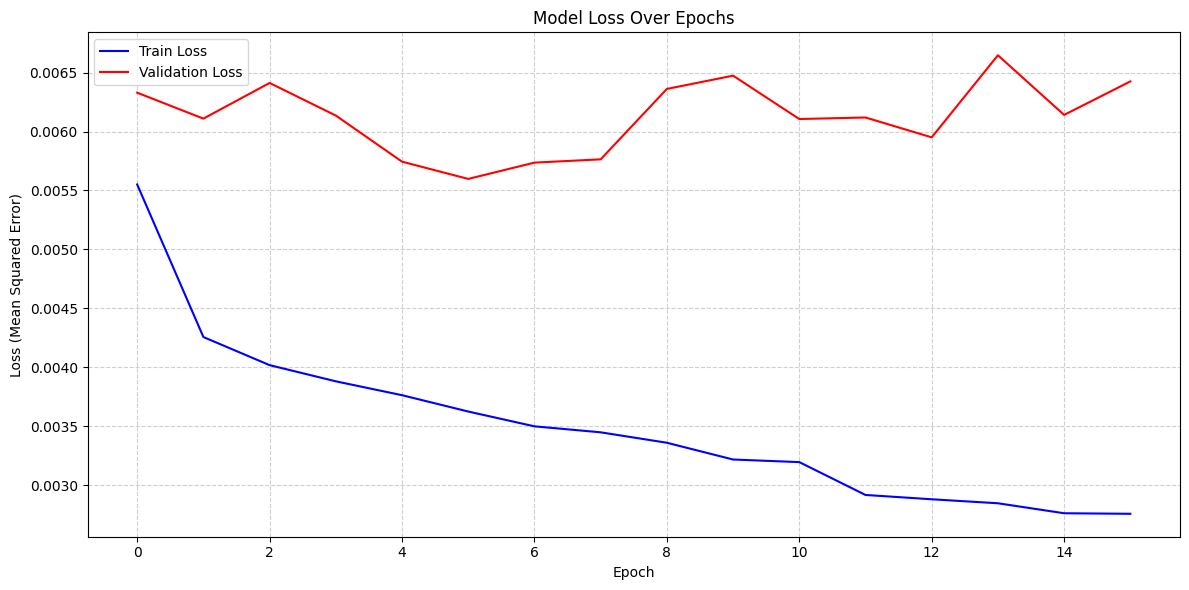

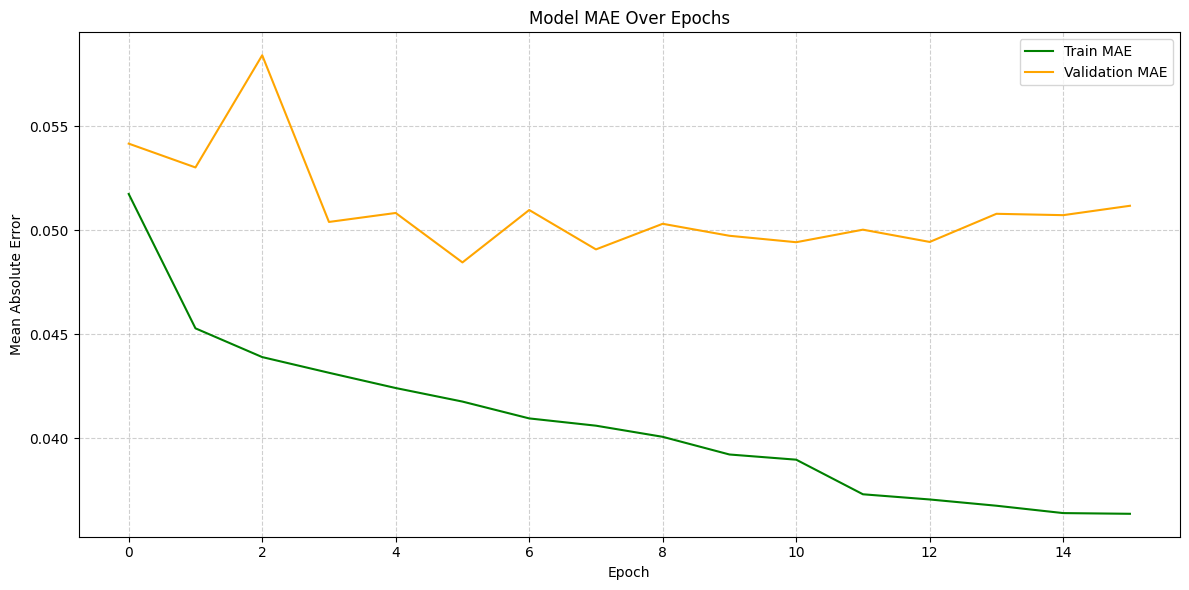

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Train MAE', color='green')
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


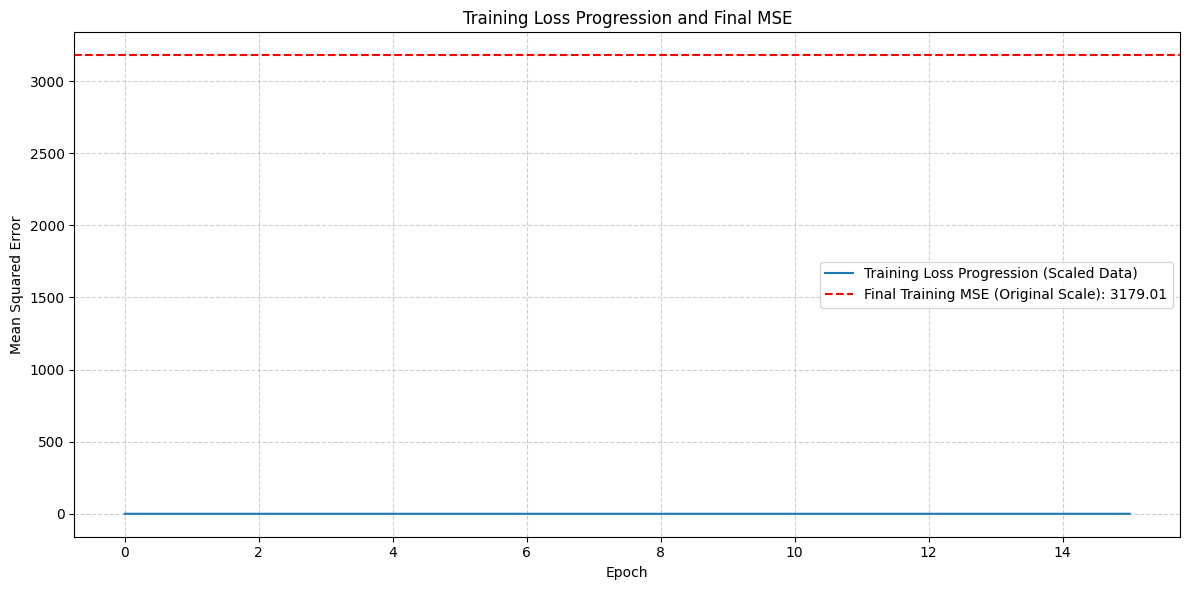

Final Training Mean Squared Error (MSE) on Original PM2.5 Scale: 3179.01
Final Training Root Mean Squared Error (RMSE) on Original PM2.5 Scale: 56.38


In [23]:
# Get predictions from the trained model on the training data (still scaled)
train_predictions_scaled = model.predict(X_train_seq)

# Inverse transform the scaled predictions back to the original PM2.5 scale
train_predictions_original_scale = scaler_y.inverse_transform(train_predictions_scaled)

# Inverse transform the actual training target values back to the original PM2.5 scale
y_train_original_scale = scaler_y.inverse_transform(y_train_seq.reshape(-1, 1))

# Calculate the Mean Squared Error (MSE) on the original scale
final_train_mse_original_scale = mean_squared_error(y_train_original_scale, train_predictions_original_scale)

# Plotting the historical training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss Progression (Scaled Data)')
plt.axhline(y=final_train_mse_original_scale, color='red', linestyle='--', label=f'Final Training MSE (Original Scale): {final_train_mse_original_scale:.2f}')
plt.title('Training Loss Progression and Final MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"Final Training Mean Squared Error (MSE) on Original PM2.5 Scale: {final_train_mse_original_scale:.2f}")

# RMSE
final_train_rmse_original_scale = np.sqrt(final_train_mse_original_scale)
print(f"Final Training Root Mean Squared Error (RMSE) on Original PM2.5 Scale: {final_train_rmse_original_scale:.2f}")

#Experiment 16

In [81]:
# Clear previous models
tf.keras.backend.clear_session()

lstm_units_1_exp = 80 # New hyperparameter for the first LSTM
lstm_units_2_exp = 40 # New hyperparameter for the second LSTM
dense_units_1_exp = 20 # New hyperparameter for the intermediate Dense layer
dropout_lstm_exp = 0.25
recurrent_dropout_lstm_exp = 0.15
dropout_dense_exp = 0.20 # Dropout for the dense layer
learning_rate_exp = 0.0005
batch_size_exp = 128
epochs_exp = 60

# --- Build the Model (with the new architecture) ---
model = Sequential([
    Input(shape=(n_steps_in, X_train_seq.shape[2])), #Input layer
    Bidirectional(LSTM(lstm_units_1_exp, activation='tanh', return_sequences=True,
                       dropout=dropout_lstm_exp, recurrent_dropout=recurrent_dropout_lstm_exp)), #1st LSTM layer
    Bidirectional(LSTM(lstm_units_2_exp, activation='tanh', return_sequences=False,
                       dropout=dropout_lstm_exp, recurrent_dropout=recurrent_dropout_lstm_exp)), #2nd LSTM layer
    Dense(dense_units_1_exp, activation='relu'), #Dense layer
    Dropout(dropout_dense_exp), #Dropout layer
    Dense(1, activation='linear') #Output layer
])


# --- Compile the Model ---
optimizer = Adam(learning_rate=learning_rate_exp)
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)
model.summary()

# --- Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)

# --- Train the Model ---
print("\nTraining the model...")
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs_exp,
    batch_size=batch_size_exp,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 160)        │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 80)             │        64,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,561 (482.66 KB)

 Trainable params: 123,561 (482.66 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 62s 245ms/step - loss: 0.0088 - rmse: 0.0932 - val_loss: 0.0087 - val_rmse: 0.0935 - learning_rate: 5.0000e-04
Epoch 2/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 76s 213ms/step - loss: 0.0064 - rmse: 0.0800 - val_loss: 0.0084 - val_rmse: 0.0917 - learning_rate: 5.0000e-04
Epoch 3/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - loss: 0.0063 - rmse: 0.0793 - val_loss: 0.0081 - val_rmse: 0.0901 - learning_rate: 5.0000e-04
Epoch 4/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 38s 199ms/step - loss: 0.0060 - rmse: 0.0773 - val_loss: 0.0084 - val_rmse: 0.0918 - learning_rate: 5.0000e-04
Epoch 5/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - loss: 0.0059 - rmse: 0.0768 - val_loss: 0.0081 - val_rmse: 0.0899 - learning_rate: 5.0000e-04
Epoch 6/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - loss: 0.0059 - rmse: 0.0768 - val_loss: 0.0078 - val_rmse: 0.0881 - learning_rate: 5.0000e-04
Epoch 7/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 207ms/step - loss: 0.0056 -

# RMSE calculation

In [82]:
# --- RMSE Calculation on Validation Set ---
# Get scaled predictions for the validation set
y_val_pred_scaled = model.predict(X_val_seq)

# Inverse transform both true and predicted values to original scale
y_val_true_unscaled = scaler_y.inverse_transform(y_val_seq.reshape(-1, 1))
y_val_pred_unscaled = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1))


# Ensure they are flat arrays for element-wise operations if they aren't already
y_val_true_unscaled = y_val_true_unscaled.flatten()
y_val_pred_unscaled = y_val_pred_unscaled.flatten()

# Apply the RMSE formula
rmse_manual = np.sqrt(np.mean((y_val_pred_unscaled - y_val_true_unscaled) ** 2))

print(f"Manual RMSE on Validation Set: {rmse_manual:.2f}")


# Calculate MSE using scikit-learn
mse_sklearn = mean_squared_error(y_val_true_unscaled, y_val_pred_unscaled)

# Calculate RMSE by taking the square root of MSE
rmse_sklearn = np.sqrt(mse_sklearn)

print(f"RMSE (scikit-learn): {rmse_sklearn:.2f}")

192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step
Manual RMSE on Validation Set: 77.40
RMSE (scikit-learn): 77.40


# Test predictions

In [83]:
test = pd.read_csv('/content/drive/MyDrive/time_series_assignment/test.csv')
test.head()
print("\ntest columns:", test.columns.tolist())
print(f"Total number of rows in raw test: {len(test)}")

# drop 'No'.
test.drop(columns=['No'], inplace=True, errors='ignore') # 'errors=ignore' prevents error if 'No' is already gone
test.set_index('datetime', inplace=True)
print("Current columns in test:", test.columns.tolist())


test columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']
Total number of rows in raw test: 13148
Current columns in test: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']


In [84]:
# Handle Missing Values in test data
print("\nMissing values in test before handling:", test.isnull().sum().sum())

# Define features for scaling
features_for_scaling = [
    'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir',
    'cbwd_NW', 'cbwd_SE', 'cbwd_cv'
]

# Scale the test data using the scaler fitted on training data.
X_test_scaled = scaler_X.transform(test[features_for_scaling])

print("\nShape of scaled test features (X_test_scaled):", X_test_scaled.shape)

# Get the last 'n_steps_in' rows of the SCALED FEATURES from the TRAINING data.
last_n_train_features = X_scaled[-n_steps_in:]

print(f"\nShape of last {n_steps_in} training features: {last_n_train_features.shape}")

# Concatenate the training tail features with the entire scaled test features.
# This creates a continuous sequence for the LSTM to draw from.
combined_test_input = np.vstack((last_n_train_features, X_test_scaled))

print(f"Shape of combined test input (train tail + test data): {combined_test_input.shape}")



Missing values in test before handling: 0

Shape of scaled test features (X_test_scaled): (13148, 9)

Shape of last 24 training features: (24, 9)
Shape of combined test input (train tail + test data): (13172, 9)


In [85]:
# --- Create Test Sequences from the Combined Input ---
def create_test_sequences(data, n_input_steps):
    X = []
    for i in range(n_input_steps, len(data)):
        X.append(data[i-n_input_steps:i, :])
    return np.array(X)

X_test_seq = create_test_sequences(combined_test_input, n_steps_in)

print(f"\nShape of test sequences X_test_seq: {X_test_seq.shape}")


Shape of test sequences X_test_seq: (13148, 24, 9)


In [86]:
# --- Make Predictions ---
print("\nMaking predictions on the test data...")
test_predictions_scaled = model.predict(X_test_seq)

final_predictions = scaler_y.inverse_transform(test_predictions_scaled)
final_predictions = final_predictions.flatten() # Make sure it's a 1D array

# No negative PM2.5 values
final_predictions[final_predictions < 0] = 0

print("\nFinal predictions (original scale):")
print(final_predictions)



Making predictions on the test data...
411/411 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step

Final predictions (original scale):
[56.83822  55.43953  53.633404 ... 16.561163 18.137392 18.631372]


In [ ]:
# --- Prepare and Save Kaggle Submission File ---
submission_ids = pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S')

submission_df = pd.DataFrame({
    'row ID': submission_ids,
    'pm2.5': final_predictions
})

submission_file_name = 'experiment16.csv'
submission_df.to_csv(submission_file_name, index=False)

print(f"\nSubmission file '{submission_file_name}' created successfully!")

# Visualization of Actual vs Predicted Values

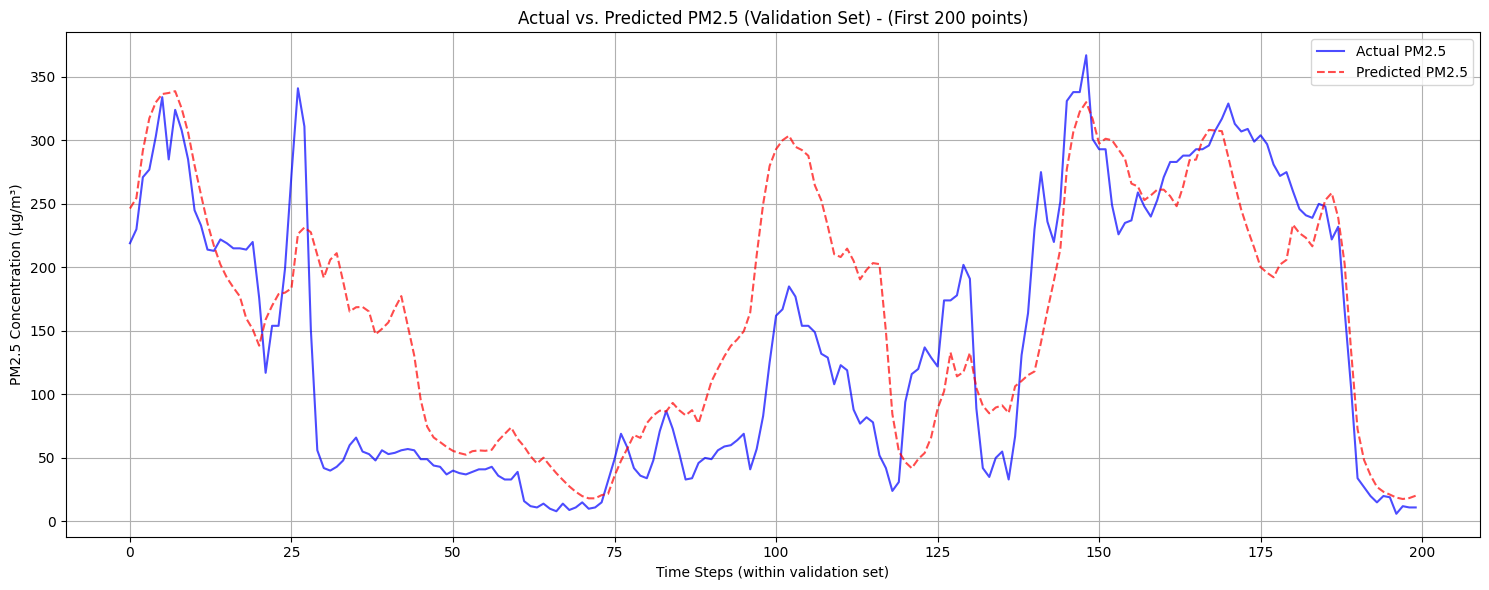

In [88]:
start_idx = 0
end_idx = 200

plt.figure(figsize=(15, 6))
plt.plot(y_val_true_unscaled[start_idx:end_idx], label='Actual PM2.5', color='blue', alpha=0.7)
plt.plot(y_val_pred_unscaled[start_idx:end_idx], label='Predicted PM2.5', color='red', linestyle='--', alpha=0.7)
plt.title(f'Actual vs. Predicted PM2.5 (Validation Set) - (First {end_idx - start_idx} points)')
plt.xlabel('Time Steps (within validation set)')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
# --- save the model ---
model_save_path = f'experiment16_model.h5'

model.save(model_save_path)

print(f"\nModel saved successfully to: {model_save_path}")


Model saved successfully to: experiment16_model.h5


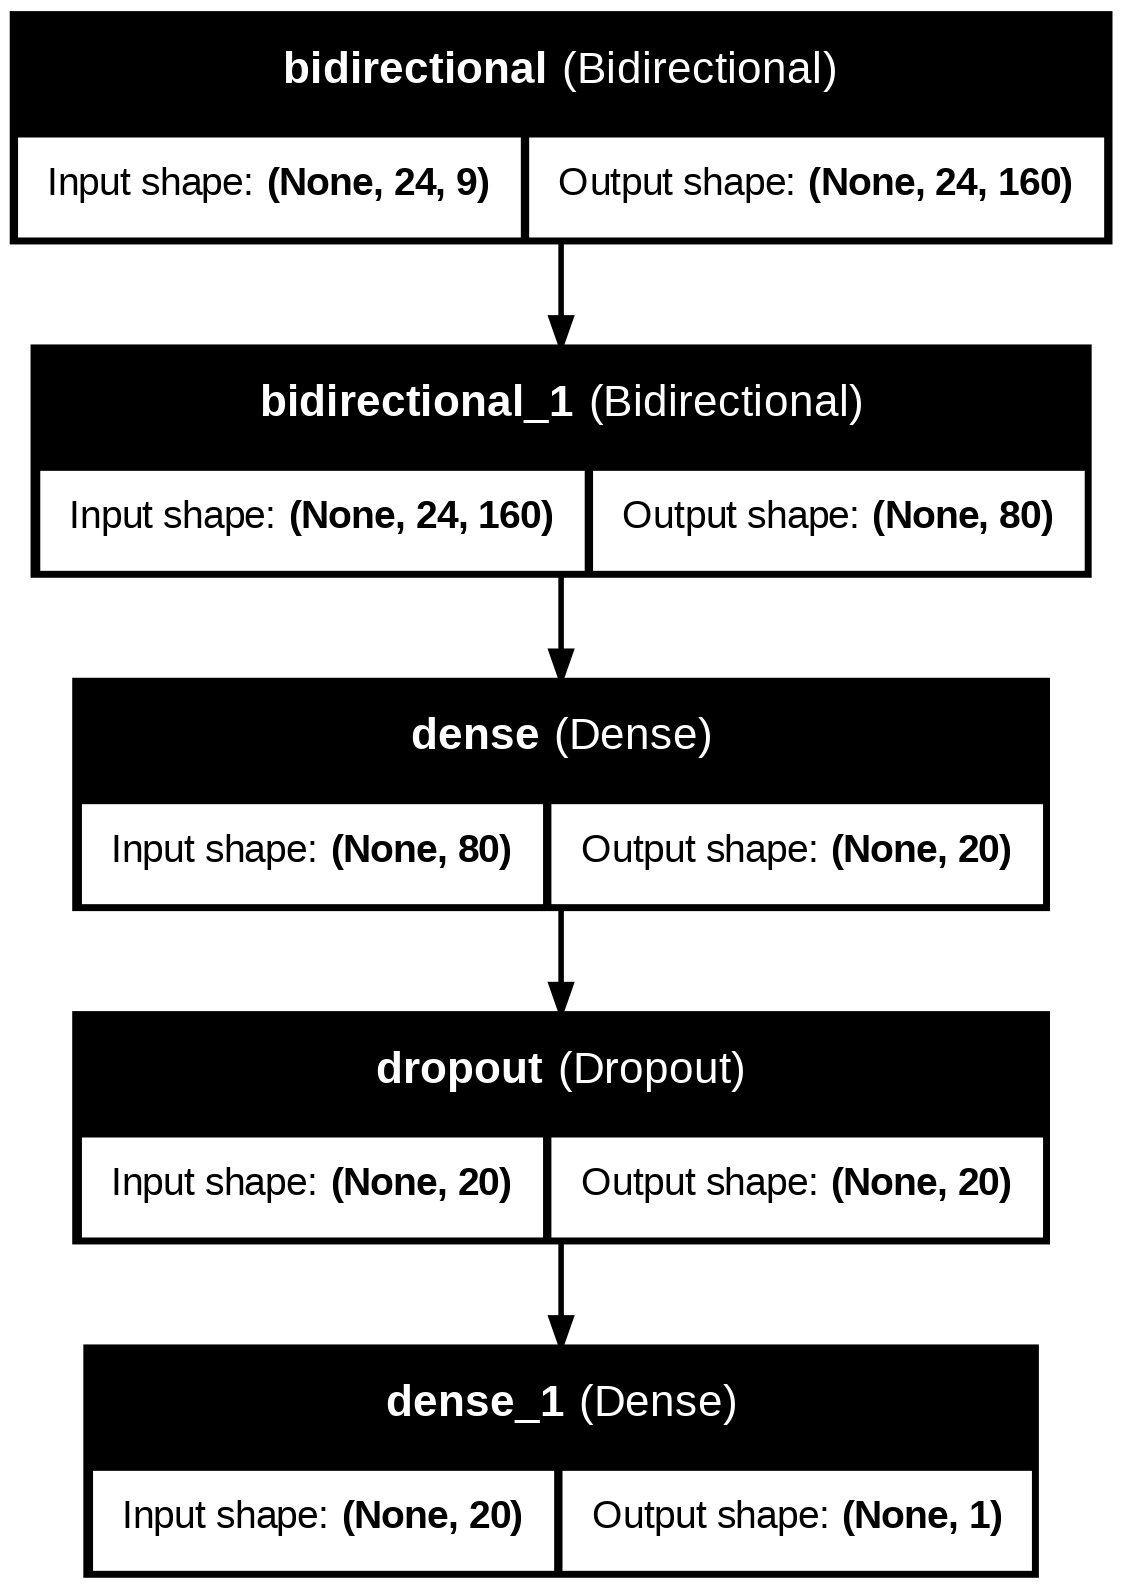

In [92]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)